In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from urllib.parse import urlparse
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD



In [2]:
data_dir = os.getcwd()
data_dir = os.path.join(data_dir, "..", "..", "Data Directory")
physics_and_chemistry_nobel_laureate = pd.read_csv(os.path.join(data_dir, "physics_and_chemistry_nobel_laureate.csv"))

# Fetch Corresponding Knowledge Graph json file for each laureate using their name
def retrieve_knowlege_graph(name_category):
    # Remove all white spaces from the name
    name = name_category['name'].replace(" ", "__")
    category = name_category['category'].lower()
    # Load the knowledge graph json file
    try:
        json = pd.read_json(os.path.join(data_dir, f"{category}_nobel_laureate", f"{name}.json"))
        return json
    except Exception as e:
        print(f"File {name}.json not found", e)

# Retrieve the knowledge graph for each laureate
physics_and_chemistry_nobel_laureate['knowledge_graph'] = physics_and_chemistry_nobel_laureate[[ 'name', 'category']].apply(retrieve_knowlege_graph, axis=1)


In [3]:
knowledge_graph = pd.concat(physics_and_chemistry_nobel_laureate['knowledge_graph'].tolist(), ignore_index=True)


# Extract the last part of the url which corresponds to the literal value of the object
def get_last_part(payload):
    parsed_url = urlparse(payload['value'])
    path = parsed_url.path
    parts = path.split('/')
    last_part = [part for part in parts if part][-1]  # This gets the last non-empty part
    return last_part

# Call get_last_part on the object column of the knowledge graph
objects = knowledge_graph['object'].apply(get_last_part).tolist()

objects

['American_Roentgen_Ray_Society',
 'Ampere',
 'Electric_charge',
 'National_Council_on_Radiation_Protection_and_Measurements',
 'William_Valentine_Mayneord',
 'Becquerel',
 'United_States',
 'Volume',
 'Dosimetry',
 'International_Commission_on_Radiation_Units_and_Measurements',
 'International_Commission_on_Radiological_Protection',
 'International_Congress_of_Radiology',
 'Second',
 'Mass',
 'Medical_imaging',
 'SI_base_unit',
 'Quartz_fiber_dosimeter',
 'Gamma_ray',
 'General_Conference_on_Weights_and_Measures',
 'Germany',
 'Equivalent_dose',
 'Louis_Harold_Gray',
 'Statcoulomb',
 '°C',
 'Kerma_(physics)',
 'USSR',
 'Wilhelm_Röntgen',
 'Cubic_centimetre',
 'Curie_(unit)',
 'European_Economic_Community',
 'Category:Units_of_radiation_dose',
 'Centimetre–gram–second_system_of_units',
 'Gray_(unit)',
 'Radiation_exposure',
 'Rad_(unit)',
 'Radiation',
 'Roentgen_equivalent_man',
 'International_System_of_Units',
 'Ionising_radiation',
 'Category:Non-SI_metric_units',
 'Absorbed_dose',

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


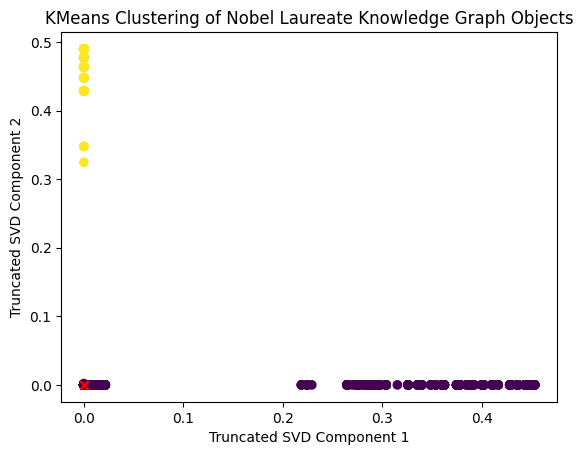

In [4]:
# Split Data into train_test_split and run KMeans clustering on the objects with 2 clusters
X_train, X_test = train_test_split(objects, test_size=0.2, random_state=42)

# Vectorize the data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Fit the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_vectorized)

# Predict the clusters for the test data
predicted_clusters = kmeans.predict(X_test_vectorized)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Use Truncated SVD for dimensionality reduction
tsvd = TruncatedSVD(n_components=2)

X_train_vectorized_tsvd = tsvd.fit_transform(X_train_vectorized)

# Visualize the clusters using a scatter plot
plt.scatter(X_train_vectorized_tsvd[:, 0], X_train_vectorized_tsvd[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x')
plt.title("KMeans Clustering of Nobel Laureate Knowledge Graph Objects")
plt.xlabel("Truncated SVD Component 1")
plt.ylabel("Truncated SVD Component 2")
plt.show()



